In [40]:
%load_ext autoreload 
%autoreload 2

import scipy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from age_balance_analysis import util
from tqdm.notebook import tqdm
from scipy.optimize import minimize_scalar, curve_fit
from scipy.linalg import expm

sns.set_style("whitegrid")

DATA_PATH = Path("../data/lysine_vacule_knockouts")
METABOLIC_LABELLING_DATA_PATH = DATA_PATH / "2024-02-28_MS_metabolites_EO_1.tsv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(0.0, 1.575)

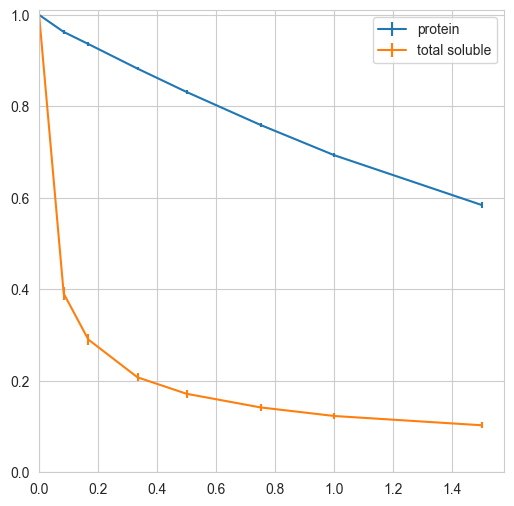

In [41]:
labelling_df = pd.read_csv(METABOLIC_LABELLING_DATA_PATH, delimiter="\t")
labelling_df["time_h"] = labelling_df.time_min / 60.0
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
for fract, group_df in labelling_df.groupby("fraction"):
    _df = group_df.pivot(index="time_h", columns="replicate", values="labelling")
    ax.errorbar(x=[0] + _df.index.tolist(), y=[1] + _df.values.mean(axis=1).tolist(), yerr=[0] + _df.values.std(axis=1).tolist(), label=fract)
ax.legend()
ax.set_ylim(0, 1.01)
ax.set_xlim(0, None)

In [42]:
labelling_df[labelling_df.fraction == "total soluble"].labelling

0     0.376624
1     0.278205
2     0.198911
3     0.162844
4     0.134033
5     0.115560
6     0.095968
7     0.404910
8     0.302344
9     0.216251
10    0.180187
11    0.149566
12    0.130497
13    0.109510
Name: labelling, dtype: float64

In [43]:
# convert the parameters to a M matrix for a model with 
# 3 states:
#   - => S1
#   - S1 <=> S2
#   - S1 => S3
#
# where 

def x_to_M(*x) -> np.ndarray:
    p0, p1, p2, p3 = tuple(x)
    return np.array([[-p0, 0, 0], [p1, -p1-p2, 0], [p3, 0, -p3]])

def f(tdata: np.ndarray, *x) -> np.ndarray:
    try:
        return np.array([expm(x_to_M(*x) * t)[-1, :].sum() for t in tdata.flat])
    except RuntimeError:
        return np.ones(tdata.shape)

_df = labelling_df[labelling_df.fraction == "total soluble"].pivot(
    index="time_h", columns="replicate", values="labelling"
)

xdata = _df.index.values
ydata = _df.values.mean(axis=1)
yerr = _df.values.std(axis=1)
popt, pcov = curve_fit(
    f=f,
    xdata=xdata,
    ydata=ydata,
    p0=np.ones(4),
    bounds=[(0, 0, 0, 0), (1e5, 1e5, 1e5, 1e5)]
)
display(popt)
tdata = np.linspace(0, 2, 100)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax.plot(tdata, f(tdata, *popt), "-")
ax.errorbar(x=[0] + xdata.tolist(), y=[1] + ydata.tolist(), yerr=[0] + yerr.tolist())


array([317.22776778,   1.        ,   1.        , 317.22776425])

<ErrorbarContainer object of 3 artists>

In [44]:
# convert the parameters to a M matrix for a model with 
# 2 states:
#   - => S1
#   - => S2
#
# where the measured labelling is for the average of both 

def f(tdata: np.ndarray, *x) -> np.ndarray:
    p0, p1, p2 = tuple(x)
    M = np.array([[-p0, 0], [0, -p1]])
    s = np.array([[p2, 1.0-p2]], ndmin=2).T
    try:
        return np.array([(expm(M * t) @ s).sum() for t in tdata.flat])
    except RuntimeError:
        return np.ones(tdata.shape)


_df = labelling_df[labelling_df.fraction == "total soluble"].pivot(
    index="time_h", columns="replicate", values="labelling"
)

xdata = _df.index.values
ydata = _df.values.mean(axis=1)
yerr = _df.values.std(axis=1)
lysine_popt, lysine_pcov = curve_fit(
    f=f,
    xdata=xdata,
    ydata=ydata,
    p0=np.ones(3),
    bounds=[(1e-3, 1e-3, 1e-3), (1e2, 1e2, 1e2)]
)
display(lysine_popt)
tdata = np.linspace(0, 1.5, 100)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax.errorbar(x=[0] + xdata.tolist(), y=[1] + ydata.tolist(), yerr=[0] + yerr.tolist(), linewidth=2)
ax.plot(tdata, f(tdata, *lysine_popt), "--", linewidth=2)

array([ 0.76421167, 19.26254444,  0.26997609])

In [45]:
lysine_p0, lysine_p1, lysine_p2 = tuple(lysine_popt)
M = np.array([[-lysine_p0, 0], [0, -lysine_p1]])
s = np.array([[lysine_p2, 1.0-lysine_p2]], ndmin=2).T
display(M, s)

array([[ -0.76421167,   0.        ],
       [  0.        , -19.26254444]])

array([[0.26997609],
       [0.73002391]])

In [46]:
LABELLING_DATA_PATH = DATA_PATH / "2024-02-19_MS_proteins_EO_3.tsv"
unfractionated_df = pd.read_csv(LABELLING_DATA_PATH, delimiter="\t").rename(
    columns={"PG.ProteinGroups": "gene"}
)
unfractionated_df["time_h"] = unfractionated_df.time_min / 60.0

In [47]:
metadata_df = unfractionated_df[
    ["experiment", "condition", "strain", "pulse_type", "temp_celsius", "time_h"]
].drop_duplicates()
metadata_df = metadata_df.groupby(["experiment", "condition", "strain", "pulse_type", "temp_celsius"]).count().time_h.reset_index().set_index("experiment")
metadata_df.rename(columns={"time_h": "num_time_points"}, inplace=True)
metadata_df = metadata_df[metadata_df.num_time_points > 1]

# Use the Biomass data to calculate the growth rates
fig, ax = plt.subplots(1, 1)
growth_rates = {}
for idx, group_df in unfractionated_df.groupby(["experiment"]):
    biomass_df = group_df.groupby(["time_h", "replicate"]).growth_dilution.mean().reset_index()
    if biomass_df.shape[0] > 1:
        linreg_result = scipy.stats.linregress(biomass_df.time_h, np.log(biomass_df.growth_dilution))
        growth_rates[idx] = -linreg_result.slope
        biomass_df.plot(x="time_h", y="growth_dilution", style=".", label=f"Exp_{idx[0]}, $\\beta$ = {growth_rates[idx]:.3g}", ax=ax)
        ax.plot([0, 3], [1, np.exp(-growth_rates[idx]*3)], 'k:')
        
ax.set_yscale("log")
metadata_df = metadata_df.join(pd.Series(growth_rates, name="growth_rate"), on="experiment")
metadata_df

condition strain           pulse_type  \
experiment                                                         
9           Y679 spike-in timecourse   Y679  spike-in timecourse   
10          Y679 spike-in timecourse   Y679  spike-in timecourse   
11          Y679 spike-in timecourse   Y679  spike-in timecourse   
12          Y679 spike-in timecourse   Y679  spike-in timecourse   

            temp_celsius  num_time_points  growth_rate  
experiment                                              
9                     30                3     0.357593  
10                    30                3     0.354332  
11                    37                3     0.340428  
12                    37                3     0.345937

In [48]:

# function for fitting protein pool based on the metabolomics result:
# 3 states:
#   - => S1
#   - => S2
#   - S1 + S2 => S3
# where the measured labelling is only for S3

def fit_f(xdata, ydata):
    
    def f(tdata: np.ndarray, *x) -> np.ndarray:
        p3,  = tuple(x)
        M = np.array([[-lysine_p0, 0, 0], [0, -lysine_p1, 0], [lysine_p2, (1.0-lysine_p2), -p3]])
        ones = np.array([1, 1, 1], ndmin=1)
        s = np.array([0, 0, 1], ndmin=1)
        try:
            return np.array([s @ expm(M * t) @ ones for t in tdata.flat])
        except RuntimeError:
            return np.ones(tdata.shape)

    popt, pcov = curve_fit(
        f=f,
        xdata=xdata,
        ydata=ydata,
        p0=np.ones(1),
        bounds=[(1e-3), (1e3)],
        full_output=False
    )
    return popt, pcov

In [49]:
result_list = []

filtered_df = unfractionated_df[(unfractionated_df.channel == "K1") & (unfractionated_df.precursor_no > 20)]

for experiment, row in metadata_df.iterrows():
    # use the Exp. and protein as the index (the 2 repeats will be pooled together)
    _df = filtered_df[filtered_df.experiment == experiment].pivot(index="gene", columns="time_h", values="labelling").dropna()
    for idx in tqdm(_df.index, desc=f"Exp_{experiment}"):
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[idx, :].to_numpy()
        bs = np.array([10,  1./row.growth_rate+1e-5])
        popt, pcov = fit_f(xdata, ydata)
        result_list.append((experiment, idx, popt[0], np.sqrt(pcov[0, 0])))

Exp_9:   0%|          | 0/103 [00:00<?, ?it/s]

Exp_10:   0%|          | 0/98 [00:00<?, ?it/s]

Exp_11:   0%|          | 0/78 [00:00<?, ?it/s]

Exp_12:   0%|          | 0/77 [00:00<?, ?it/s]

In [50]:
result_df = pd.DataFrame(result_list, columns=["experiment", "gene", "p3", "p3_std"])
result_df

experiment     gene        p3    p3_std
0             9     AAT2  0.473336  0.035634
1             9     ACC1  0.465279  0.018200
2             9     ACO1  0.479000  0.024674
3             9     ACO2  0.341040  0.033332
4             9     ACS2  0.513203  0.032901
..          ...      ...       ...       ...
351          12     VAS1  0.451101  0.043422
352          12     VMA1  0.485593  0.033615
353          12     YEF3  0.436035  0.044540
354          12  YHR020W  0.458513  0.041953
355          12  YNL247W  0.427075  0.050579

[356 rows x 4 columns]

(0.0, 1.0)

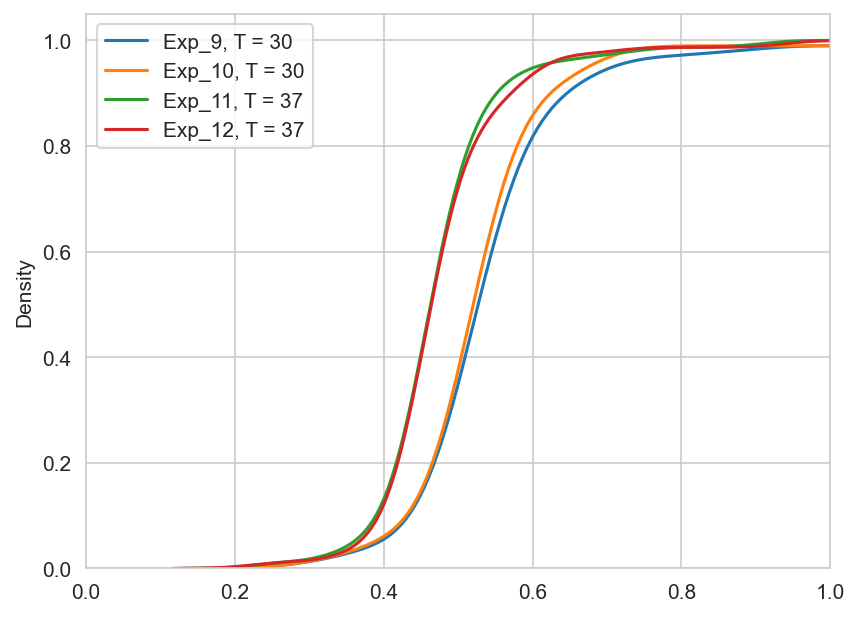

In [52]:
fig, ax = plt.subplots(1, 1, dpi=150)
for experiment, row in metadata_df.iterrows():
    pool_data = result_df[result_df.experiment == experiment].p3.values
    sns.kdeplot(pool_data, ax=ax, cumulative=True, label=f"Exp_{experiment}, T = {row.temp_celsius}")
ax.legend()
ax.set_xlim(-0, 1.0)